# 뉴스 요약하기
루브릭  
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.  
분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.  
모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.  
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.  
두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.

### 데이터 수집 및 전처리

In [1]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')
import tensorflow
import summa
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

In [2]:
# 데이터 다운로드
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
10325,Mizoram Police backs demand for 40 central for...,The Mizoram Police has supported the demand of...
12250,We've no sympathy for Anirban: KWAN CEO on #Me...,After celebrity management agency KWAN Enterta...
40052,MIT researchers develop world's first 'psychop...,Researchers at MIT have developed an artificia...
19031,ISRO to launch 19 missions in next 7 months,"ISRO will conduct 19 missions, including 10 sa..."
8123,"Who is Madhumala, who befriended Andaman triba...",Former Anthropological Survey of India researc...
1365,"Punjab boy scores 100 percentile in JEE Main, ...",Punjab's 18-year-old Jayesh Singla is one of t...
57111,Two women including a Congress leader found de...,"Two women, including a district Congress leade..."
32921,Man breaks into eatery as he was 'drunk' and '...,A 22-year-old man has confessed to breaking in...
15590,BCCI announces Harmanpreet-led squad for Women...,The BCCI's All India Women's Selection Committ...
70305,"22 students, 2 wardens killed in fire at Malay...",At least 22 students and two wardens died in a...


데이터 전처리의 기본인 null 값과 중복값 배제, 노드에서 제시한 정규화 사전 및 불용어 제거까지 차용하였다.(정규화 사전과 불용어 제거는 100% 노드 차용함)

In [4]:
# null 값은 없는 것으로 확인된다.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# 중복값 배제
data.drop_duplicates(subset = 'text', inplace=True)

In [7]:
# 텍스트 정규화(사전은 100% 노드 복붙)
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
# 데이터 전처리 함수(불용어 포함)
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [9]:
# temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
# temp_summary = 'Great way to start (or finish) the day!!!'

# print("text: ", preprocess_sentence(temp_text))
# print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

In [10]:
clean_text = []
# 전체 Text 데이터에 대한 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_headlines[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [12]:
data['text'] = clean_text
data['headlines'] = clean_headlines

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98360 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98360 non-null  object
 1   text       98360 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


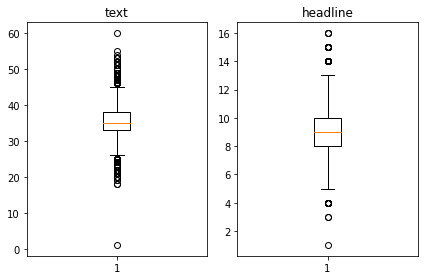

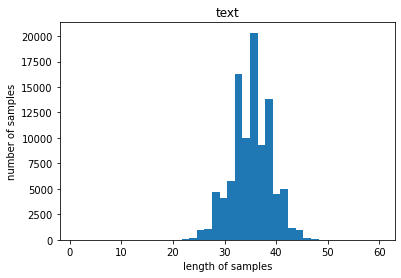

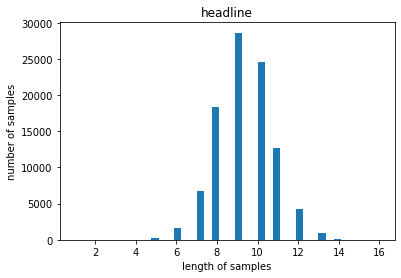

In [15]:
# headline과 text의 최대 길이를 구하기 위하여 시각화
import matplotlib.pyplot as plt
import numpy as np
text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headline_len)
plt.title('headline')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
# 최대 길이 정함
text_max_len = 45
headline_max_len = 12

In [17]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [19]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96871


In [20]:
# decoder_input과 decoder_output에 각각 시작토큰, 종료토큰 붙여줌
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


train 데이터와 test 데이터를 나눈 뒤 토크나이징을 진행한다.

In [21]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[31532 26042  4833 ... 42868 73053  9214]


In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19374


In [25]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [27]:
# 단어 토큰의 구성 확인
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69217
등장 빈도가 5번 이하인 희귀 단어의 수: 45331
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23886
단어 집합에서 희귀 단어의 비율: 65.49113657049568
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.1123414268464886


In [28]:
# 단어집합의 크기 제한, Tokenizer는 빈도가 큰 단어부터 토크나이징한다.
src_vocab = 23000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[803, 1188, 1, 6107, 1589, 2261, 2077, 1, 2077, 1908, 267, 580, 680, 11158, 539, 2261, 2077, 589, 11, 2077, 2102, 1188, 4, 906, 8057, 2898, 400, 2261, 2077], [3061, 487, 2219, 6819, 18218, 809, 4499, 438, 2150, 1680, 552, 11159, 2054, 8327, 989, 67, 6, 1261, 2884, 14193, 357, 2219, 552, 2536, 31, 2785, 477, 6198, 35, 2353, 694, 3400, 2375], [1604, 973, 3251, 4102, 1357, 43, 342, 634, 482, 50, 243, 148, 483, 418, 1013, 1127, 786, 273, 44, 232, 582, 196, 22, 6, 70, 235, 684, 196, 786, 19295, 411, 148, 418, 1013, 6478, 103, 668, 5239, 530, 63]]


In [30]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [31]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29914
등장 빈도가 4번 이하인 희귀 단어의 수: 18414
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11500
단어 집합에서 희귀 단어의 비율: 61.55646185732433
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.996117438667743


In [32]:
tar_vocab = 11500
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 433, 19, 7620, 3540, 4, 4501, 2166, 724, 668], [1, 77, 194, 3541, 1797, 4, 4220, 764, 3202, 244], [1, 454, 301, 572, 52, 413, 2942, 2817, 1543, 470, 49, 802], [1, 1422, 1179, 111, 77, 6], [1, 123, 471, 205, 107, 6, 1977, 4653, 89, 993, 107, 617]]
target
decoder  [[433, 19, 7620, 3540, 4, 4501, 2166, 724, 668, 2], [77, 194, 3541, 1797, 4, 4220, 764, 3202, 244, 2], [454, 301, 572, 52, 413, 2942, 2817, 1543, 470, 49, 802, 2], [1422, 1179, 111, 77, 6, 2], [123, 471, 205, 107, 6, 1977, 4653, 89, 993, 107, 617, 2]]


In [33]:
# 데이터의 길이가 1인 경우의 인덱스를 저장 후 삭제.. 하려 했으나 그런 경우는 없음을 확인함
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')

### 모델 설계하기

In [35]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [36]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [37]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2944000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [38]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2944000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
303/303 [==============================] - 56s 105ms/step - loss: 5.7386 - val_loss: 5.3214
Epoch 2/50
303/303 [==============================] - 31s 103ms/step - loss: 5.1256 - val_loss: 4.9094
Epoch 3/50
303/303 [==============================] - 32s 106ms/step - loss: 4.7864 - val_loss: 4.6626
Epoch 4/50
303/303 [==============================] - 33s 108ms/step - loss: 4.5330 - val_loss: 4.4680
Epoch 5/50
303/303 [==============================] - 33s 108ms/step - loss: 4.3285 - val_loss: 4.3319
Epoch 6/50
303/303 [==============================] - 33s 108ms/step - loss: 4.1558 - val_loss: 4.2207
Epoch 7/50
303/303 [==============================] - 33s 108ms/step - loss: 4.0087 - val_loss: 4.1271
Epoch 8/50
303/303 [==============================] - 33s 109ms/step - loss: 3.8802 - val_loss: 4.0640
Epoch 9/50
303/303 [==============================] - 33s 108ms/step - loss: 3.7675 - val_loss: 4.0006
Epoch 10/50
303/303 [==============================] - 33s 108ms/step - l

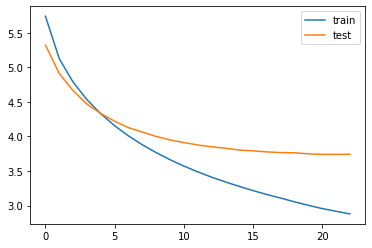

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 실제 요약문 도출 및 비교

In [41]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [42]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [43]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [48]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [49]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headline(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [50]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headline(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : actress asha parekh thursday said union minister nitin gadkari claim chased padma bhushan hurtful right thing matter controversies part film industry added parekh told entitled award contributions gadkari claimed 
실제 요약 : gadkari saying chased padma bhushan asha parekh 
예측 요약 :  do not know what is not in my film anupam on


원문 : elon musk led aerospace startup spacex sunday scrapped planned launch spy satellite us military last minute launch due family sensor issue startup attempt launch secretive payload orbit falcon rocket monday 
실제 요약 : spacex scraps launch of us spy satellite at the last minute 
예측 요약 :  spacex to launch us military if he is not


원문 : tirumala tirupati devasthanams accused stealing ornaments lord venkateswara temple andhra decided exhibit jewellery end controversy jewellery put display media june theft allegations made former ttd chief priest ramana slapped crore defamation case 
실제 요약 : to exhibit tirumala temple jewellery amid theft allegations 
예측 요약 :  

예측 요약 :  hackers crore crore hit by wannacry hit by


원문 : us man arrested reports showed year old son died consuming times lethal dose methamphetamine thinking breakfast man reportedly refused call emergency services incident charged possession well neglect led death dependent 
실제 요약 : yr old dies after mistaking dad meth for breakfast 
예측 요약 :  man kills self after being stabbed to death in us


원문 : ukraine reportedly paid us president donald trump lawyer michael cohen crore set meeting leaders two countries ukraine registered reached cohen talks could arrange photo op ukrainian president petro poroshenko trump reports said leaders met white house last year 
실제 요약 : ukraine paid trump lawyer cr to meeting report 
예측 요약 :  trump orders nato to meet white house in white house


원문 : high court catalonia ordered us tech giant google delete application said catalan separatists using spread information region independence spain court said application opposed order spain constitutional co

예측 요약 :  india should be like the global if we are not change


원문 : data breach incidents india higher compared global average according survey defence grade technology maker around indian respondents reported data breach last year way global average around according report indian companies million billion revenue covered report 
실제 요약 : data breach incidents in india higher than global average 
예측 요약 :  india among top companies in india report


원문 : asteroid size stadium past earth wednesday distance million kilometres times average distance earth moon named vr metre wide asteroid initially considered potentially hazardous next observed first discovered november hawaii based nasa funded observatory 
실제 요약 : asteroid zooms past earth safely 
예측 요약 :  asteroid asteroid asteroid earth at the last years


원문 : delhi year old air hostess batra allegedly texted friend two hours jumping house building husband mayank singhvi locked inside room call police going kill today mayank driven ano

의미가 들어맞는 경우는 드물지만 묘하게 실제 요약문과 비슷한 단어를 출력한다. 반쪽짜리 성공이라 보는 것이 맞는 듯 하다. 애초에 노드의 summary과제는 headline을 뽑아내는 것보다 훨씬 간단하기 때문에 이런 문제가 발생한 것 같다.

### 추출적 요약

In [51]:
import requests
from summa.summarizer import summarize

In [52]:
text = data['text'][0]

In [53]:
text

'saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'

In [58]:
print('Summary:')
print(summarize(text, ratio=1))

Summary:



In [59]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
[]


In [60]:
print('Summary:')
print(summarize(text, words=5))

Summary:



뉴스의 짧은 문장으로는 summa에서 제대로 요약하지 못하는 것으로 보아, medium의 기술블로그 텍스트를 가져와 보았다.

In [61]:
text="""Now that everyone is talking about ChatGPT, I’m finding myself dodging some version of this question more often:

“Will AI fully exit the realm of science fiction and begin to change everything?”

The reason I usually nope out of this question is that there’s some sneaky sleight of hand in there which ensures that intelligent discussion will be dead on arrival. That’s because language is a slippery eel and there’s no law against people using the same word to mean different things in different contexts, but let me indulge the question just this once.

There’s no law against people using the same word to mean different things in different contexts. That’s what’s happening when people talk about AI these days.

Let’s look at some of the ways that people are using the term AI to talk past one another. When we see those for what they are, the answer to our slippery question will slither into the light of day all by itself.

Homonym 1: The AI made up by writers
The AI you’ll find in the pages of science fiction novels is entirely made up! Most of the time, it plays the same role in the narrative as all the other conveniently creepy almost-but-not-quite-human entities — demons, clones, demigods, aliens, golems, spirits, talking animals, animated puppets — that force us to confront what it means to be human. I hope no one is surprised that the sentient human-adjacent evil antagonist version of AI doesn’t exist.

Hate to disappoint, but a murderous HAL 9000 isn’t going to be piloting your spaceship anytime soon.


Photo by Rod Long on Unsplash
Science fiction is simply called “fiction” when it doesn’t stay ahead of technology, so in a breathtaking display of how tautological tautologies can be, let’s get this version of the question out of the way: will every science fiction version of AI fully exit science fiction? No. Science fiction will keep writing about new tomorrows.

The sentient human-adjacent evil antagonist version of AI doesn’t exist.

I’m that special type of curmudgeon who thinks it’s a crime against intelligence to talk about machine “intelligence”, “sentience”, “consciousness”, and “the singularity” without first defining clearly and unambiguously what these words mean to you. It’s not cute to work yourself (and your audience) into a frenzy by saying a whole lot of nothing, but unfortunately that’s what so many discussions on these topics turn into.

As for making artificial humans with all our desires, feelings, and foibles… why would anyone even want to do that?

As for making artificial humans with all our desires, feelings, and foibles… why would anyone even want to do that? If you stop to think about it, that smells so much more like a plot device in a novel than like a serious goal. Regardless of whether you’re a bleeding heart or have no heart at all, if you wanted machines that could be most useful to you and/or humanity, you’d opt to build them without selfishness and other less lovable aspects of human nature. Whereas if you simply need more humans, buy me a beer so I can explain exactly how they’re made.


Image source: Pixabay
To be sure, there are great reasons to worry about AI, but the it-reminds-me-of-me uncanny valley stuff is a distraction. Since I’d need a separate whole blog post to explain this, I’ve… written a separate blog post for you here.

Forget the robots! Here’s how AI will get you
The real reason AI is more dangerous than traditional software
towardsdatascience.com

Homonym 2: The AI people like me are talking about
In tech, we use the term “AI” to refer to a specific way of turning data into computer code. When you see someone automate a task using patterns in data without looking up the answer directly, they’re probably using machine learning to solve their problem. If it’s a particular type of machine learning algorithm, then it’s polite to call it AI, though etiquette never stopped certain “AI” startups from jumping on the bandwagon with their three IF statements in a trenchcoat. (You know who you are.)


If you'd like to meet the real AI, check out this excerpt from my machine learning course on YouTube.
So, has this version of AI already exited the realm of science fiction? Absolutely, since it never even entered it. Even before all the AI applications we use every day were launched, the people doing serious work on them were calling them AI, fully aware that they weren’t creating anything that would pass muster with either science fiction fans or professors of neuroscience. It’s just a flashy name for some math. Aren’t homonyms fun?

But as it turns out, that math is incredibly useful! It enables all kinds of interesting applications, and you interact with them every day. They’ve been “changing everything” for the last decade, from our smartphones and laptops to our cars and homes. This kind of AI is quiet and unassuming, and it makes our lives more convenient without drawing attention to itself.

Every time I see someone “fail” a Turing test, it tells me a great deal more about the person than about the machine.

And that same math happens to be useful for processing audiovisual data so it’s a solid ingredient for all those parlor tricks you’d need to fool the gullible into thinking you’ve built a sentient being. But every time I see someone “fail” a Turing test, it tells me a great deal more about the person than about the machine.


Just because telekinesis looks real to you doesn’t mean magic is real. Just because you can’t tell a machine’s not a human doesn’t mean it is sentient. I'm perpetually surprised by a world in which professional magicians and the Turing test can coexist. Photo by Fengyou Wan on Unsplash
Finally, I’d be remiss if I didn’t mention that there are two more homonyms nested inside the one in this section — the AI that’s more associated with academia and the AI that’s more associated with industry. If you’re curious about the difference between two more homonyms, check out my explainer in “Why Businesses Fail At AI.”

Questions to sink your teeth into
“Will AI fully exit the realm of science fiction and begin to change everything?” The answer is tautological either way. You’ll answer no by simply reminding yourself of any reasonable definition of science fiction and you’ll also answer no because applied AI hasn’t had all that much to do with the science fiction version for at least this millennium.

There’s no more controversy here than two groups talking at cross purposes without defining their terms. Instead, let me try to extract some properly controversial questions from this homonym soup:

Will the popularity of practical AI kill science fiction’s AI? I could see an argument for the term becoming too mundane to be compelling… perhaps one day an AI antagonist will be as hard to take seriously as a disgruntled toaster. Will science fiction writers need to look for other entities to fill their uncanny valleys? My guess is no — if creepy dolls are good enough for the fiction community, then apparently anything goes — but what do you think?
Did the builders of practical AI solutions do the right thing by allowing their marketing teams to capitalize on science fiction hype in order to secure funding and gain attention? How different would technological progress have been if we stuck to terms like “layered weighted sums of nonlinear data transformations” instead of flashy phrases like “artificial intelligence” and “neural networks”?
Should we let nature take its course and let the public continue to confuse practical AI with sci-fi AI, or do we need to actively educate people about the differences between the two? If you’re interested in my thoughts on why it’s dangerous for society to conflate the two, check out my blog post titled “Forget the Robots, Here’s How AI Will Get You.”
Excited to hear your thoughts as you digest these chewy questions — join the discussion here."""

In [63]:
print('Summary:')
print(summarize(text, ratio=0.1))

Summary:
“Will AI fully exit the realm of science fiction and begin to change everything?”
Science fiction is simply called “fiction” when it doesn’t stay ahead of technology, so in a breathtaking display of how tautological tautologies can be, let’s get this version of the question out of the way: will every science fiction version of AI fully exit science fiction?
Homonym 2: The AI people like me are talking about
So, has this version of AI already exited the realm of science fiction?
Even before all the AI applications we use every day were launched, the people doing serious work on them were calling them AI, fully aware that they weren’t creating anything that would pass muster with either science fiction fans or professors of neuroscience.
“Will AI fully exit the realm of science fiction and begin to change everything?” The answer is tautological either way.


In [67]:
print('Summary:')
print(summarize(text, ratio=0.1, split=True))

Summary:
['“Will AI fully exit the realm of science fiction and begin to change everything?”', 'Science fiction is simply called “fiction” when it doesn’t stay ahead of technology, so in a breathtaking display of how tautological tautologies can be, let’s get this version of the question out of the way: will every science fiction version of AI fully exit science fiction?', 'Homonym 2: The AI people like me are talking about', 'So, has this version of AI already exited the realm of science fiction?', 'Even before all the AI applications we use every day were launched, the people doing serious work on them were calling them AI, fully aware that they weren’t creating anything that would pass muster with either science fiction fans or professors of neuroscience.', '“Will AI fully exit the realm of science fiction and begin to change everything?” The answer is tautological either way.']


In [68]:
print('Summary:')
print(summarize(text, words=100))

Summary:
Science fiction is simply called “fiction” when it doesn’t stay ahead of technology, so in a breathtaking display of how tautological tautologies can be, let’s get this version of the question out of the way: will every science fiction version of AI fully exit science fiction?
So, has this version of AI already exited the realm of science fiction?
“Will AI fully exit the realm of science fiction and begin to change everything?” The answer is tautological either way.


원문과 가까운 뜻이라고 보기는 어렵지만 오히려 원문보다는 더 문장같은 말들이 만들어졌다. 왠만해서는 추상적 요약이 추출적 요약보다 월등할 것이라고 머리로는 생각하지만 혹시 문장의 성격에 따라 반전될 수도 있겠다는 생각 역시 들기 시작했다.

회고  
근 1~2주의 노드들이 난이도가 대폭 상승하여 따라가지 못하는 점이 안타깝다. 그 전까지는 무언가 시도해보고 변경시켜볼 여유가 있었던 것 같은데 그 조차도 어려움이 느껴져 어떻게든 과제를 완수하겠다고 복붙을 하다 보니 약간 자괴감도 든다. 앞으로 방학 전까지 유사한 상황이 반복될 것 같다 생각하면 이게 뭐하는 것인가 싶기도 한다.  
하지만, 그 안에서도 최대한 무언가를 가져가 보도록 노력해 보련다. 나를 책임질 수 있는 것은 나 뿐이니...